# Building a Generative Pre-trained Transformer (GPT)

In this notebook we implement a decoder only Transformer, which can be trained for character level prediction. The network has a self-attention and fully connected layer. It doesn't implement the cross-attention. The original paper implements the model for language transaltion, therefore it has a decoder and encoder. 

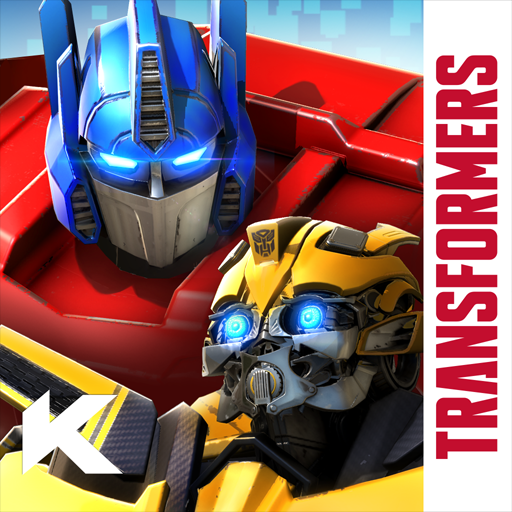

**References**:

[1] https://www.youtube.com/watch?v=kCc8FmEb1nY&t=8s&ab_channel=AndrejKarpathy

In [97]:
!nvidia-smi

Wed Feb  8 13:36:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load data

In [64]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-02-08 13:36:06--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.006s  

2023-02-08 13:36:07 (167 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [65]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [66]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## Encoding the text

Get all unique characters in the text

In [67]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


Simple encoding scheme:

Encode each character with its associdated position in the `chars` list. This encoding scheme is simple, but produces long sequences.

In [68]:
# create a mapping from characters to integers
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [69]:
len(encode("hii there")), len("hii there")

(9, 9)

Lets encode the whole text

In [70]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

## Creating batches of sequnces

*How do we create the sequences ?*

Take the following chunks of the encoded text
(note that y is shifted x by a single index).

```python
x = [18, 47, 56, 57, 58,  1, 15, 47]
y = [47, 56, 57, 58,  1, 15, 47, 58]
```

from sequneces x and y we can compute the following set up training examples:

```python
input: [18] target: [47]
input: [18,47] target: [56]
input: [18,47,56] target: [57]
...
```

*Why such representation makes sense ?*

This allows to train the Transformer network with context of different size (*from a single character of context, up to block_size of context*). This helps us in the inference stage, where we input a single character in the transformer and let it roll (predict the next character) up to the block size.

Split data into train and validation

In [71]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [72]:
block_size = 8 # also known as context_len
train_data[:block_size+1] # this sequence gives us 9 examples

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [73]:
x = train_data[:block_size]   
y = train_data[1:block_size+1]

print(len(x), len(y))

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

8 8
when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


Batches:

We should use many batches of multiple chunks of text, that are stacked up in a single tensor

In [74]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the **maximum** (could be anything from 1 char to block_size) context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    # generate **batch_size** number of random idx into the data
    ix = torch.randint(len(data) - block_size, (batch_size,))

    # iterate over the random idx and generate seq. (x) and targets (y)
    # us the same ofset scheme as above.
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


In [75]:
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53, 56, 1, 58, 46] the target: 39
when input is [44, 53, 56, 1, 58, 46, 39] the target: 58
when input is [44, 53, 56, 1, 58, 46, 39, 58] the target: 1
when input is [52] the target: 58
when input is [52, 58] the target: 1
when input is [52, 58, 1] the target: 58
when input is [52, 58, 1, 58] the target: 46
when input is [52, 58, 1, 58, 46] the target: 39
when input is [52, 58, 1, 58, 46, 39] the t

In [76]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


Walk through the code above

In [77]:
# generate batch_size number of random idx into the data
idxs = torch.randint(len(data) - block_size, (4,))
idxs

tensor([1081275,  241627,  748567,  905830])

In [78]:
[i for i in idxs]

[tensor(1081275), tensor(241627), tensor(748567), tensor(905830)]

In [79]:
# index into data at individual random idxs and take samples of length
# block_len
[data[i: i + block_size] for i in idxs]

[tensor([53, 59, 56,  0, 41, 39, 40, 47]),
 tensor([63, 53, 59,  1, 39, 50, 50,  6]),
 tensor([ 0, 24, 17, 27, 26, 32, 17, 31]),
 tensor([ 1, 39, 52, 42,  1, 59, 52, 56])]

In [80]:
# stacked them up
out = torch.stack(
    [data[i: i + block_size] for i in idxs]
)

out, out.shape # [batch_size, seq_len]

(tensor([[53, 59, 56,  0, 41, 39, 40, 47],
         [63, 53, 59,  1, 39, 50, 50,  6],
         [ 0, 24, 17, 27, 26, 32, 17, 31],
         [ 1, 39, 52, 42,  1, 59, 52, 56]]), torch.Size([4, 8]))

## Building the bigram language model

In [81]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


In [82]:
# generate from the new_line characters
idx= torch.zeros((1, 1), dtype=torch.long) # zeros represent the new line character
chars_to_gen=100
# jeyyy we get gibberish :)
print(decode(m.generate(idx, max_new_tokens=chars_to_gen)[0].tolist()))


SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


#### Walk through the bigram language model

##### Emebbeding layer


The shape of the embedding layer is (vocab_size, vocab_size). At forward pass we index into the embedding layer using the index from the vocab_size. 

In [83]:
import torch.nn as nn
vocab_size

embbed_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=vocab_size)

# we can pass a single character (encoded) to the embedding table
print(f"char: \n{text[0]}")
print(f"encoded_char: \n{encode(text[0])}")
t = torch.tensor(encode(text[0]))
print(f"embedding (of the encoded_char): \n{embbed_table(t)}")

char: 
F
encoded_char: 
[18]
embedding (of the encoded_char): 
tensor([[-0.9960,  0.4784,  0.6830,  0.0184, -0.3239, -0.4817, -2.2855,  0.0689,
         -0.3846,  2.4278,  1.0926, -0.4928, -0.7596, -0.6907,  1.3629,  1.0483,
         -0.0830, -0.5062, -0.2883, -1.0564,  0.4821, -0.3602, -0.5296, -0.5252,
          0.5893, -0.1434, -2.0540,  1.3761, -0.0931, -0.8209, -0.9345, -0.0467,
         -0.4622, -0.8404,  1.0731, -0.7762, -0.9206, -0.4602, -1.0767,  0.9798,
         -1.7843,  0.3633,  0.3902,  0.9898, -1.1291,  0.1767,  1.6688,  1.0262,
          1.8673,  0.5224,  0.9860,  0.6640,  0.9294,  0.8634,  1.3989, -0.6709,
         -0.4065,  1.6494, -0.2960,  1.4390,  0.0865, -1.5175, -0.7835, -0.6413,
          0.0439]], grad_fn=<EmbeddingBackward0>)


In [84]:
# now lets take a sample form the batch
print(xb[0].shape)               # [block_size]
print(embbed_table(xb[0]).shape) # [block_size, embedding_dim]

torch.Size([8])
torch.Size([8, 65])


In [85]:
# finally lets embedd the whole batch
print(xb.shape)
print(embbed_table(xb).shape) # [batch_size, block_size, embedding_dim]

torch.Size([4, 8])
torch.Size([4, 8, 65])


##### Computing the Cross entropy Loss

In [86]:
from torch.nn import functional as F

logits = embbed_table(xb) # [batch_size, block_size, embedding_dim]
print(logits.shape, yb.shape)

torch.Size([4, 8, 65]) torch.Size([4, 8])


In [87]:
# We have to reshape the tensor before we can feed them into the cross_entropy loss
batch_size, block_size, embeddin_dim = logits.shape
logits = logits.view(batch_size * block_size, embeddin_dim)
yb = yb.view(batch_size * block_size)

logits.shape, yb.shape

(torch.Size([32, 65]), torch.Size([32]))

In [88]:
# now we can compute the loss
F.cross_entropy(logits, yb)

tensor(4.6911, grad_fn=<NllLossBackward0>)

##### Character Generation

In [89]:
logits = embbed_table(xb)
print(logits.shape) # [batch_size, block_size, embedding_dim]

torch.Size([4, 8, 65])


In [90]:
# take only the last element in the time dimension
# this are the predictions for what comes next

logits = logits[:, -1, :] # [batch_size, embedding_dim]
print(logits.shape)

torch.Size([4, 65])


In [91]:
# get the distribution over embedding_dim (recall that this is vocab_len)
# so we get the prob. distribution over all possible characters
probs = F.softmax(logits, dim=-1)
print(probs.shape)

torch.Size([4, 65])


In [92]:
# sample form the distribution
idx_next = torch.multinomial(probs, num_samples=1)
print(idx_next)
print(idx_next.shape)

tensor([[39],
        [22],
        [61],
        [49]])
torch.Size([4, 1])


In [93]:
# add the just predicted characters to the xb
torch.cat(
    (xb, idx_next),
    dim=1 # concatenate idx_next over columns
)

tensor([[24, 43, 58,  5, 57,  1, 46, 43, 39],
        [44, 53, 56,  1, 58, 46, 39, 58, 22],
        [52, 58,  1, 58, 46, 39, 58,  1, 61],
        [25, 17, 27, 10,  0, 21,  1, 54, 49]])

### Training the bigram model

In [94]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3) # typical: lr=3e-4, for smaller networks we can use a larger lr

In [95]:
batch_size = 32

for steps in range(10000): # increase number of steps for good results... 
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.493375778198242


In [96]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


KENG wicomoue int at se,
Cortr mou oneny grom be;
mva-Bino in y llican fer wid.


MIt
O:


OLAfobont aiee;
Anlone aves ve t fo mnd h ve g ay' th,
He heng-piur Yom: nee
MPrny
haiolersceangen
Bur we harplo ho pleich thalk wiriteamithe in, ow
Jute mbeneno hard SHO:

Tht bith;

An: se'
Ox, sodout ws myot:
Fothar, whe shef; pr,
Wesith
pu wotif$
TER:
Fispinou banks y whocois arioofunce trd thir omiththio tas ofe, aly d beanerok GSclaves.
Y shay wacometend hy, s.

Whel ove bu grdde.
wolke IO: anedede




## The matchematical trick in self-attention

***Tokens should communicate with each other (with a caveat)***

We would like this tokens *T* to "talk to each other" (i.e we would like to cupple the tokens). Tokens should be cuppled in the following way: token at the *i*-th location can only be cuppled with token before the *i*-th location

***How can the tokens communicate ?***

If we are the *i*-th token and wan't to communicate with the previus tokens, we can just take the mean of the previous tokens. This can formally be written as follows: 

$x[b,t] = mean_{i<=t} (x[b,i])$ 


In [33]:
# consider the following toy example:
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

Inefficient implementation

In [40]:
x[0], x[0].shape

(tensor([[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]]), torch.Size([8, 2]))

In [37]:
#take the first four rows
x[0, :0 + 4] # [T, C]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643]])

In [41]:
torch.mean(x[0, :0 + 4], axis=0) # [1, C]

tensor([ 0.3504, -0.2238])

In [42]:
xbow = torch.zeros((B,T,C))
for b in range(B): # iterate over batch
    for t in range(T): # iterate over the block_size

        # take 
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

In [43]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [46]:
xbow[0] # note that the first row is the same as the one in x (we computed the mean of just the first row)

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

**Efficient implementation (using matrix multiplication)**


In [58]:
# lower triangular matrix
a = torch.tril(torch.ones(3,3))
a

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [59]:
# sum over the columns (for each row)
# this is just the number of non zero elements in each row
torch.sum(a, axis=1, keepdim=True)

tensor([[1.],
        [2.],
        [3.]])

In [60]:
# normalize by the number of non zero elements
a = a / torch.sum(a, 1, keepdim=True)
a

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

In [61]:
# lets take a look at some dummy data matrix
b = torch.randint(0,10,(3,2)).float()
b

tensor([[8., 6.],
        [5., 2.],
        [4., 4.]])

In [62]:
# we can see that after matrix multiplication
# the rows in matrix c are the mean of rows in b
c = a @ b
c

tensor([[8.0000, 6.0000],
        [6.5000, 4.0000],
        [5.6667, 4.0000]])

In [99]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [119]:
# consider the following toy example:
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [107]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)

# batch matrix multiplication
# individual matrix mult. for each sample in batch
# for one batc: (T, T) @ (T, C) -> (T, C)

# (B, T, T) @ (B, T, C) ----> (B, T, C)
xbow2 = wei @ x
# check if the vectorized and original version returns the same output
torch.allclose(xbow, xbow2)

True

We'll use the following version for self attention, lets brake it down bellow.






In [120]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T)) # bottom triangular matrix
wei = torch.zeros((T,T))            # matrix of just zeros
wei = wei.masked_fill(tril == 0, float('-inf')) # make wei -inf where tril is zero (upper triangle)
wei = F.softmax(wei, dim=-1)        # softmax along the row (exp. each element in row and devide by the sum of the exp. row)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

In [121]:
tril = torch.tril(torch.ones(T, T))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

`wei` is initially zero (we can think of this as the intercation strength, i.e how much of each token in the past do we wan't to average out). This so called affinities are data dependent (meaning that they will get learned).

In [122]:
wei = torch.zeros((T,T))
wei

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

The line bellow tells us that token that have a -inf (future tokens) associated with them, cannot be used to predict the next token. In other words this insures that the future cannot communicate with the past.

In [123]:
wei = wei.masked_fill(tril == 0, float('-inf'))
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [124]:
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [125]:
xbow3 = wei @ x

## Self attention

Lets implement a small self attention for a single head.

Every single token or node at each position will emit two vectors: query (*what am i looking for ?*), key(*what do i contain ?*). To get affinities we perform a dot product between querys and a keys. 

Intuition: a query of a single token dot products with keys (of all the other tokens), if the key and a query are aligned than we get a large interaction (meaning that the token with this speciic key, plays a large role). 

In [146]:
torch.manual_seed(1337)
B, T, C = 4, 8, 32  # [batch_size, time, channels]
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 32])

In [147]:
# let's see a single Head perform self-attention
head_size = 16 # hyper-parameter
key   = nn.Linear(C, head_size, bias=False) # this will just apply matrix multiplication
query = nn.Linear(C, head_size, bias=False) # this will just apply matrix multiplication
value = nn.Linear(C, head_size, bias=False) # this will just apply matrix multiplication

In [148]:
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)

k.shape, q.shape

(torch.Size([4, 8, 16]), torch.Size([4, 8, 16]))

Lets perform the dot product between quires and the keys

In [149]:
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

In [150]:
wei.shape # every batch has a different wei (since each batch contains diff. data)

torch.Size([4, 8, 8])

Each token (encodded with embedding and position) creates a query, e.g *I am a vowel at the 8th position, and am looking for a any consonants (a, e, i, o, u) in any position up to 4.*. Than all the tokens get to emit keys, e.g *I am a consonant and am at position up to 4*. This example query and token would have high affinitiy, meaning that thourgh the softmax we will aggregate lots of its information into my position.


BTW: affinity (the degree to which a substance tends to combine with another)


In [151]:
wei[0]

tensor([[-1.7629, -1.3011,  0.5652,  2.1616, -1.0674,  1.9632,  1.0765, -0.4530],
        [-3.3334, -1.6556,  0.1040,  3.3782, -2.1825,  1.0415, -0.0557,  0.2927],
        [-1.0226, -1.2606,  0.0762, -0.3813, -0.9843, -1.4303,  0.0749, -0.9547],
        [ 0.7836, -0.8014, -0.3368, -0.8496, -0.5602, -1.1701, -1.2927, -1.0260],
        [-1.2566,  0.0187, -0.7880, -1.3204,  2.0363,  0.8638,  0.3719,  0.9258],
        [-0.3126,  2.4152, -0.1106, -0.9931,  3.3449, -2.5229,  1.4187,  1.2196],
        [ 1.0876,  1.9652, -0.2621, -0.3158,  0.6091,  1.2616, -0.5484,  0.8048],
        [-1.8044, -0.4126, -0.8306,  0.5899, -0.7987, -0.5856,  0.6433,  0.6303]],
       grad_fn=<SelectBackward0>)

Text(0, 0.5, 'Affinitiy')

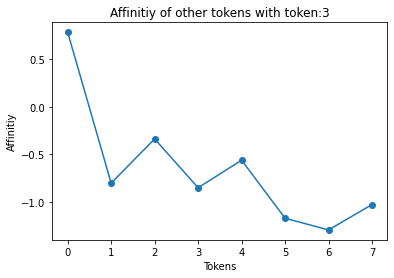

In [155]:
import matplotlib.pyplot as plt
token_idx = 3

plt.plot(wei[0][token_idx, :].tolist(), "o-")
plt.title(f"Affinitiy of other tokens with token:{token_idx}")
plt.xlabel("Tokens")
plt.ylabel("Affinitiy")

But recall that if we are the third token (node) we should not use the tokens after the third index

In [158]:
tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4183, 0.5817, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3176, 0.3137, 0.3687, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2733, 0.2410, 0.2448, 0.2408, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1917, 0.1941, 0.1923, 0.1917, 0.2302, 0.0000, 0.0000, 0.0000],
        [0.1619, 0.1684, 0.1620, 0.1617, 0.1845, 0.1615, 0.0000, 0.0000],
        [0.1432, 0.1489, 0.1408, 0.1407, 0.1419, 0.1439, 0.1406, 0.0000],
        [0.1234, 0.1243, 0.1239, 0.1267, 0.1239, 0.1241, 0.1269, 0.1268]],
       grad_fn=<SelectBackward0>)

Now lets replote this the affinity for the third token (taking into account that we can't build connections with future tokens)

Text(0, 0.5, 'Affinitiy')

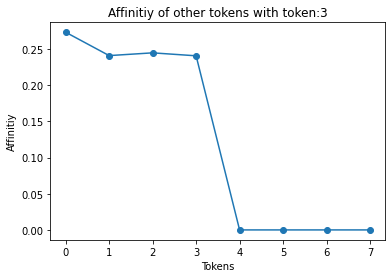

In [160]:
token_idx = 3

plt.plot(wei[0][token_idx, :].tolist(), "o-")
plt.title(f"Affinitiy of other tokens with token:{token_idx}")
plt.xlabel("Tokens")
plt.ylabel("Affinitiy")

Finally lets aggregate with the output of the value layer. We can think of x as private information to this token. 

In [161]:
v = value(x)
out = wei @ v
#out = wei @ x

out.shape # [batch_size, batch_size, head_size]

torch.Size([4, 8, 16])

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights. *In our case: we have `block_size` nodes (tokens), the first node is only pointed to by iteself, the second node is only pointed to by the first node and iteself, ..., the last node is pointed to by all previus nodes and itself (in language modeling this is the typicall structure of the graph).*

- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other. *In other wordl attention is just a set of vectors that communicaty but have no notion of space in order to add the notion of space we encode the positions. Also note that element across the batch_dimension are processed indipendetly, meaning that they don't talk to each other.*

- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling. *In other words, if we are for example doing sentement analysis or doing language transaltion, we allow attention over the whole input. In this case we would use the encoder block, which doesn't use the masking (i.e we allow all the nodes to talk).*

- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module).


### "Scaled" attention

"Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

If we don't scale the output, the variance of wei is in the order of head_size.

In [166]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1)
wei.var()

tensor(15.9317)

If we scale by $1 / \sqrt{\text{head_size}}$, we get variance of 1.0 

In [162]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

*Why is this important ?*

Because we feed the output to a softmax, if `wei` takes very positive and very negative number, than the output of softmax will converge to one-hot vectors.

Text(0, 0.5, 'Soft-max output')

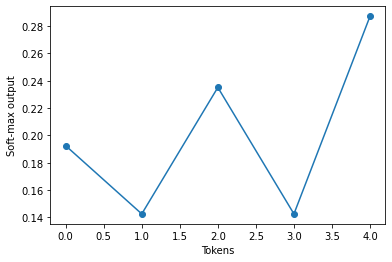

In [176]:
plt.plot(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1).tolist(), "o-")
plt.xlabel("Tokens")
plt.ylabel("Soft-max output")

If softmax converges to one-hot vectors, than we are agreggating information only from a single node (**we don't want this !!!**)

Text(0, 0.5, 'Soft-max output')

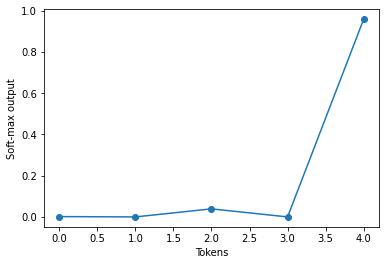

In [177]:
# gets too peaky, converges to one-hot
plt.plot(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*head_size, dim=-1).tolist(), "o-")
plt.xlabel("Tokens")
plt.ylabel("Soft-max output")

### Implementing a one Head of self attentions

In [179]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

In [180]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()

        # create a key, query, value linear layers
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        # lets create a tril matrix (note that we have to register it)
        self.register_buffer(
            'tril', 
            torch.tril(torch.ones(block_size, block_size))
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Compute the keys and the queries
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)

        # Compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        
        # Makaes sure that the future doesn't communicate with the past
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)

        # Perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)

        return out

### Lets stick the sealf attention Head in the Bigram Model

We'll add the following: first we'll add the position embedding table and than the self attention head.

In [181]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # Apply the word embedding
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        
        # Apply the position embedding
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)

        # Pass the context vector (x) to self attention head
        x = self.sa_head(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
       # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        
        return idx

## Multi-head attention

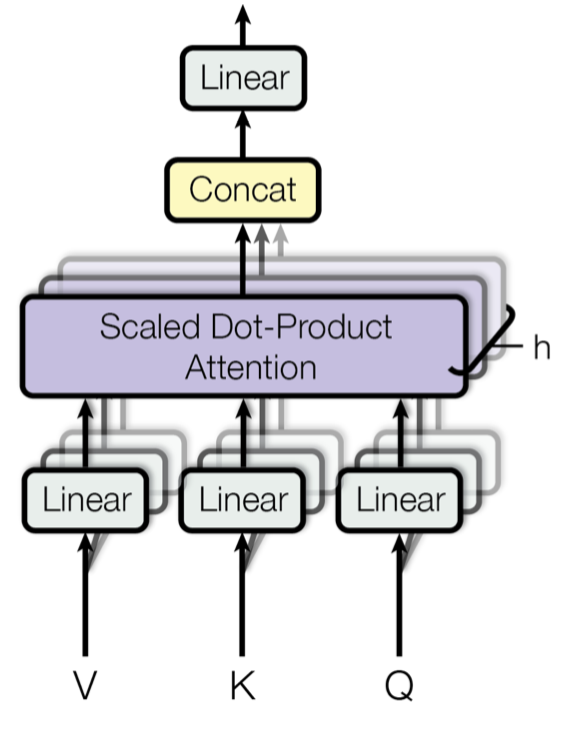

**Idea**: lets use multiple self attention Heads in parallel. This allows us to have multiple communication channels.

In [183]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()

        # create multiple heads
        self.heads = nn.ModuleList(
            [Head(head_size) for _ in range(num_heads)]
        )

    def forward(self, x):
        # run all of them in paralle, and concat. over the channel
        # dimension. 
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return out

### Adding the fully connected layer


We should add a fully connected layer to the output of the self attention head. The layer is applied on per token level.

## Full code

Things to keep in mind when training deep nerual networks:

- Skip connections (*add a path that simply adds the current output to the next layer, recall that the backprop though the addition simply passes the gradient along, this is the graident "highway" connection*). Implementing this is as simple as: `x = x + self_attention(x)`. 

- Layer Normalization (*We normalize the rows, not the columns; like in batch normalization*)

- Dropout (*shut off a subset of neurons, and train without them, this internally train an ansamble of networks.*)

In [184]:
class LayerNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))